# <center>Modelo de detecção de quedas usando CNN</center>

## Pré processamento dos dados

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import splitfolders

In [2]:
full_dataset = pd.read_csv('full_dataset.csv', index_col=0)
full_dataset.head()

,video_name,tag,start,end
0,Coffee_room_01-video (25).avi,fall,75,175
1,Coffee_room_02-video (56).avi,fall,250,350
2,Home_02-video (57).avi,nonfall,100,200
3,Home_02-video (59).avi,nonfall,100,200
4,Coffee_room_01-video (38).avi,fall,175,275


In [3]:
batch_size = 64
img_height = 224
img_width = 224
EPOCHS = 10
IMG_SHAPE = (img_width, img_height) + (3,)
data_dir = "full_image_dataset_100f"
output="output"
splitfolders.ratio(data_dir, output="output", seed=123, ratio=(0.75, 0.05, 0.20))

Copying files: 188 files [00:00, 8706.20 files/s]


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output, "train"),
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output, "val"),
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    os.path.join(output, "test"),
    target_size=(img_height, img_width),
    seed=123,
    shuffle=True,
    batch_size=batch_size)

Found 141 files belonging to 2 classes.
Found 8 files belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [5]:
# Classes do modelo
class_names = train_ds.class_names
print(class_names)

['fall', 'nonfall']


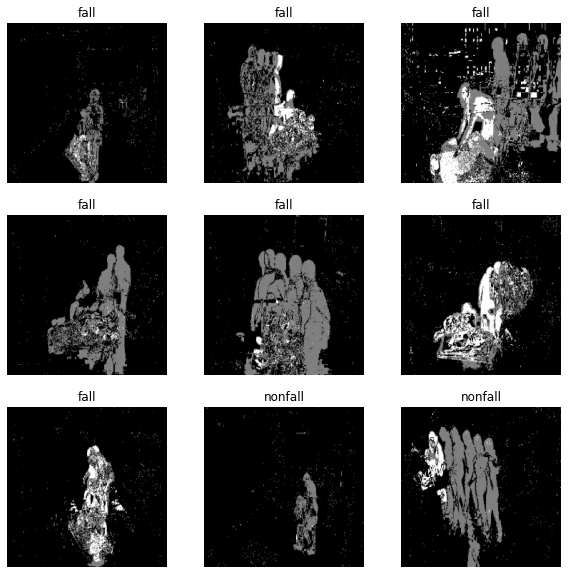

In [6]:
# Algumas imagens
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Tamanho do lote com as amostras e os seus rótulos
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [8]:
# AUTOTUNE para aumentar a performance durante a estapa de treinamento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

## Etapa de Classificação

### Definição do classificador

In [10]:
# Definição da arquitetura com a cabeça de classificação
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
#x = data_augmentation(inputs)
#x = preprocess_input(x)
#x = preprocess_input(inputs)
#x = base_model(x, training=False)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.AveragePooling2D((3, 3))(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((3, 3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(64,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(32,activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Resumo do modelo gerado
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        8256      
_________________________________________________________________
average_pooling2d_1 (Average (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 64)        16448     
_________________________________________________________________
average_pooling2d_2 (Average (None, 11, 11, 64)        0     

### Treinamento do Modelo

In [11]:
# Definição da função callback para salvar o modelo com melhor acurácia na validação
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treinamento do modelo com ajuste aos dados
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
3/3 [==============================] - 3s 688ms/step - loss: 6.5137 - accuracy: 0.5532 - val_loss: 6.2429 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 2s 506ms/step - loss: 4.4418 - accuracy: 0.6383 - val_loss: 6.3333 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 2s 486ms/step - loss: 3.7559 - accuracy: 0.6738 - val_loss: 5.6326 - val_accuracy: 0.6250
Epoch 4/10
3/3 [==============================] - 2s 470ms/step - loss: 3.0261 - accuracy: 0.7305 - val_loss: 5.0147 - val_accuracy: 0.6250
Epoch 5/10
3/3 [==============================] - 2s 478ms/step - loss: 2.7190 - accuracy: 0.7163 - val_loss: 4.2413 - val_accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 2s 496ms/step - loss: 2.3171 - accuracy: 0.7234 - val_loss: 3.5261 - val_accuracy: 0.6250
Epoch 7/10
3/3 [==============================] - 2s 462ms/step - loss: 1.2605 - accuracy: 0.8085 - val_loss: 3.0238 - val_accuracy: 0.6250
Epoch 8/10
3/3 [====

## Resultado do treinamento

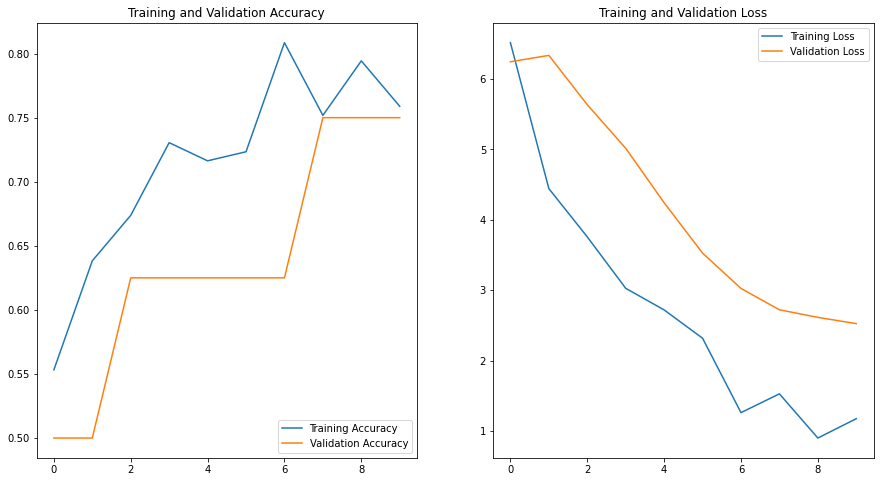

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)

In [14]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [15]:
from sklearn.metrics import classification_report

y_pred = np.argmax(pred,axis=1).astype('int32')
y_true = test_generator.classes
labels = list(labels.values())
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

        fall       0.64      0.70      0.67        20
     nonfall       0.65      0.58      0.61        19

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39



In [16]:
from sklearn.metrics import accuracy_score
print('Accuracia no Treino: %.2f' % (np.mean(val_acc)*100),'%')
print('Accuracia no Teste: %.2f' % (accuracy_score(y_true, y_pred)*100),'%')

Accuracia no Treino: 63.75 %
Accuracia no Teste: 64.10 %


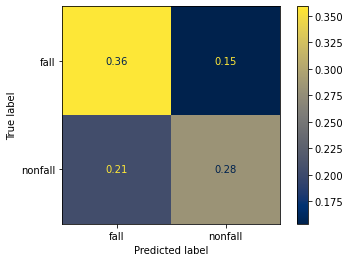

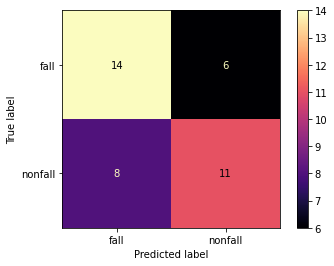

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Com normalização
cm = confusion_matrix(y_true, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['fall','nonfall'])
cmd.plot(cmap='cividis')

# Por amostras
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['fall','nonfall'])
cmd.plot(cmap='magma')

In [18]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
display(results)
#results.to_csv("results.csv",index=False)

,Filename,Predictions
0,fall/Coffee_room_01-video (13).jpg,fall
1,fall/Coffee_room_01-video (15).jpg,fall
2,fall/Coffee_room_01-video (2).jpg,fall
3,fall/Coffee_room_01-video (21).jpg,nonfall
4,fall/Coffee_room_01-video (25).jpg,fall
5,fall/Coffee_room_01-video (29).jpg,fall
6,fall/Coffee_room_01-video (4).jpg,nonfall
7,fall/Coffee_room_01-video (42).jpg,fall
8,fall/Coffee_room_01-video (6).jpg,fall
9,fall/Coffee_room_01-video (7).jpg,fall
